In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np

%matplotlib inline
#%matplotlib tk
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls
from src.Atomic import Collision, SEsolver

from src.Util import Class

from src.Visual import Grotrian, Plotting

import src.Constants as Cst
from src.Atomic import LTELib

from src.Function.StatisticalEquilibrium import LibClass as SELib
from src.Function.StatisticalEquilibrium import LibArray

from src.Atomic import Hydrogen

---

In [5]:
atom, paths = AtomCls.InitAtom("../../data/conf/H.conf", isHydrogen=True)

---

---

## Einstein `Aji` coeficient

In [ ]:
ni_arr = atom.Line.idxI[:] + 1
nj_arr = atom.Line.idxJ[:] + 1
Aji = Hydrogen.Einstein_A_coefficient(ni_arr, nj_arr)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)
ax.plot( Aji[:], 'o', markersize=4, label="calculation")
ax.plot( atom.Line.AJI[:], label="NIST" )

ax.legend(loc="best")
ax.set_yscale("log")
ax.set_title("Johnson1972")
ax.set_ylabel("$A_{ji} \; [s^{-1}]$")
plt.show()

## Collisional Excitation rate coefficient

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6
ni = 1
for nj in range(ni+1, k+1):
    Cij = Hydrogen.CE_rate_coe(ni,nj,Te)
    ax.plot( Te, Ne*Cij, '--o', markersize=4, label=f"ni={ni}-->nj={nj}" )

ax.legend(loc="best")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")

ax.set_title("Johnson1972")
ax.set_ylabel("$N_{e}C_{ij} \; [s^{-1}]$")
plt.show()

## Collisional ionization rate coefficient

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=100, sharey=True)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6

functions = {
    "Johnson1972" : Hydrogen.CI_rate_coe,
    "Clark+1991"  : Hydrogen.CI_rate_coe_Clark,
}

for i, name in enumerate(functions.keys()):
    ax = axs[i]
    for ni in range(1, k+1):
        Cik = functions[name](ni,Te)
        ax.plot( Te, Ne*Cik, '--o', markersize=4, label=f"ni={ni}-->nj={nj}" )
        ax.legend(loc="best")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(name)
        ax.set_ylabel( "$N_{e}C_{ik} \; [s^{-1}]$" ) if i==0 else None
        ax.set_xlabel( "$T_{e} \; [K]$" )

plt.show()

**let's use *Johnson1972* version**

## bound-free Gaunt factor

In [ ]:
x = np.linspace(1, 2, 11)

fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=100, sharey=True)

functions = {
    "Johnson1972" : Hydrogen.Gaunt_factor,
    "Gingerich+1991"  : Hydrogen.Gaunt_factor_Gingerich,
}

for i, name in enumerate(functions.keys()):
    ax = axs[i]
    for ni in range(1,8):
        g = functions[name](ni, x)
        ax.plot( x, g, '--o', markersize=3, label=f"ni={ni}" )
        ax.legend(loc='best')
        ax.set_title(name)
        ax.set_xlabel("$E_{transition}/E_{ik}$")
        ax.set_ylabel("bound-free Gaunt factor") if i==0 else None


plt.show()

**let's use *Johnson1972* version**

## photoionization cross section

In [ ]:
x = np.linspace(1, 2, 11)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

functions = {
    "Photoionization cross section" : Hydrogen.PI_cross_section,
}

for i, name in enumerate(functions.keys()):
    for ni in range(1,8):
        alpha = functions[name](ni, x, 1)
        ax.plot( x, alpha, '--o', markersize=3, label=f"ni={ni}" )
        ax.legend(loc='best')
        ax.set_title(name)
        ax.set_ylabel("$\\alpha \; [cm^{2}]$")
        ax.set_xlabel("$E_{transition}/E_{ik}$")


plt.show()

## Spontaneous radiative recombination

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=100, sharey=True)

n = 21
#Te = np.logspace(3.8, 6, n)
Te = np.linspace(6000, 2E4, n)
Ne = 1E10

for ni in range(1, 8):
    RCki = Hydrogen.Rki_spon_rate_coe(ni,Te)
    ax.plot( Te, Ne*RCki, '--o', markersize=4, label=f"continuum-->ni={ni}" )
    ax.legend(loc="best")

Tr = 6E3

Rki_spon_arr = []
for t in range(Te.shape[0]):
    n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te[t], Ne)
    Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te[t], nj_by_ni_Cont, _Tr=Tr)
    Rki_spon_arr.append( Rki_spon )
Rki_spon_arr = np.array( Rki_spon_arr )

ax = axs[1]
for ni in range(1, 8):
    ax.plot( Te, Rki_spon_arr[:,ni-1], '--o', markersize=4, label=f"continuum-->ni={ni}" )
    ax.legend(loc="best")
    ax.set_yscale("log")
    ax.set_title("Integration")


ax = axs[0]
for ni in range(1, 8):
    RCki = Hydrogen.Rki_spon_rate_coe(ni,Te)
    ax.plot( Te, Ne*RCki, '--o', markersize=4, label=f"continuum-->ni={ni}" )
    ax.legend(loc="best")
    ax.set_yscale("log")
    ax.set_title("Johnson1972")

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")
ax.set_ylabel("$R_{ki}^{spon} \; [s^{-1}]$")
plt.show()

**let's use integration of photoionization cross section**

## Statictical Equilibrium

In [ ]:
Te = 1E4
Ne = 1E11
Tr = 6E3

# n_LTE : LTE population (summed up to 1)
# nj_by_ni_Line : nj/ni for line transitions
# nj_by_ni_Cont : nj/ni for Continuum transitions
n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne)

Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)

##  ij : ij + ik
Cij = SELib.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

n_SE = SELib.solve_SE(atom, 
                     Ne, Cji, Cij, 
                     Bji_Jbar, Bij_Jbar, 
                     Rki_spon, Rki_stim, Rik)

In [ ]:
print(f"Electron temperature  = {Te:.1E}")
print(f"Electron density      = {Ne:.1E}")
print(f"Radiation temperature = {Tr:.1E}")
print('-'*35)
print("SE  :")
for v in n_SE:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in n_LTE:
    print(f"{v:.4E}",end="  ")

## Ionization fraction v.s. Electron temperature

In [ ]:
nTe = 51
Te = np.linspace(3E3, 2E4, nTe)

Ne = 1E10
Tr = 6E3

eta = {
    "LTE": np.zeros(nTe),
    "SE" : np.zeros(nTe),
}

for k in range(nTe):
    n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te[k], Ne)

    Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te[k], nj_by_ni_Cont, _Tr=Tr)
    Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)

    ##  ij : ij + ik
    Cij = SELib.get_Cij(atom, Te[k])
    Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

    n_SE = SELib.solve_SE(atom, 
                         Ne, Cji, Cij, 
                         Bji_Jbar, Bij_Jbar, 
                         Rki_spon, Rki_stim, Rik)
    
    eta["LTE"][k] = n_LTE[-1] / n_LTE[:].sum()
    eta["SE"][k] = n_SE[-1] / n_SE[:].sum()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=120)

for i, name in enumerate(eta.keys()):
    ax.plot(Te[:], eta[name][:], '--o', markersize=3, label=name)
    
ax.set_xlabel("$T_{e} \; [K]$")
ax.set_ylabel("$ n_{H\, II} \; / \; n_{H} $")
ax.legend(loc="best")
ax.set_title("ionization fraction v.s. eletron temperature")
plt.show()

## Ionization fraction v.s. Electron density

In [ ]:
Te = 8E3
nNe = 51
Ne = np.logspace(8,15, nNe)
Tr = 6E3

eta = {
    "LTE": np.zeros(nNe),
    "SE" : np.zeros(nNe),
}

for k in range(nNe):
    n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne[k])

    Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
    Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)

    ##  ij : ij + ik
    Cij = SELib.get_Cij(atom, Te)
    Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

    n_SE = SELib.solve_SE(atom, 
                         Ne[k], Cji, Cij, 
                         Bji_Jbar, Bij_Jbar, 
                         Rki_spon, Rki_stim, Rik)
    
    eta["LTE"][k] = n_LTE[-1] / n_LTE[:].sum()
    eta["SE"][k] = n_SE[-1] / n_SE[:].sum()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=120)

for i, name in enumerate(eta.keys()):
    ax.plot(Ne[:], eta[name][:], '--o', markersize=3, label=name)
    
ax.set_xlabel("$N_{e} \; [cm^{-3}]$")
ax.set_ylabel("$ n_{H\, II} \; / \; n_{H} $")
ax.legend(loc="best")
ax.set_xscale('log')
ax.set_title("ionization fraction v.s. eletron density")
plt.show()

## ionization fraction ($T_{e},N_{e}$)

In [ ]:
nTe = 61
Te = np.linspace(5E3, 2E4, nTe)
nNe = 61
Ne = np.logspace(8,14, nNe)
Tr = 6E3

eta = {
    "Local Termal Equil.": np.zeros((nNe,nTe)),
    "Statistical Equil." : np.zeros((nNe,nTe)),
    "Coronal Equil." : np.zeros((nNe,nTe)),
}

for nn in range(nNe):
    for nt in range(nTe):
        n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te[nt], Ne[nn])

        Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te[nt], nj_by_ni_Cont, _Tr=Tr)
        Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)

        ##  ij : ij + ik
        Cij = SELib.get_Cij(atom, Te[nt])
        Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

        n_SE = SELib.solve_SE(atom, 
                             Ne[nn], Cji, Cij, 
                             Bji_Jbar, Bij_Jbar, 
                             Rki_spon, Rki_stim, Rik)

        eta["Local Termal Equil."][nn,nt] = n_LTE[-1] / n_LTE[:].sum()
        eta["Statistical Equil."][nn,nt] = n_SE[-1] / n_SE[:].sum()
        
        ##-- Coronal Equilibrium
        Bji_Jbar[:] = 0
        Bij_Jbar[:] = 0
        Rki_stim[:] = 0
        Rik[:]      = 0
        n_CE = SELib.solve_SE(atom, 
                             Ne[nn], Cji, Cij, 
                             Bji_Jbar, Bij_Jbar, 
                             Rki_spon, Rki_stim, Rik)
        eta["Coronal Equil."][nn,nt] = n_CE[-1] / n_CE[:].sum()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150)
plt.subplots_adjust(wspace=0.03)

for ax, name in zip( axs, eta.keys() ):
    im = ax.imshow(eta[name][:,:], cmap="inferno", origin="lower", vmin=1.E-9, vmax=1.)
    
    Plotting.set_imshow_ticks(ax, Te, axis='x',points=4, fmt='%1.0f',rot=0)
    Plotting.set_imshow_ticks(ax, np.log10(Ne), axis='y',points=4, fmt='%1.0f',rot=0)
    ax.set_title("$ n_{H\, II} \; / \; n_{H} $" + f"  {name}")

axs[0].set_ylabel("$N_{e} \; [cm^{-3}]$")
axs[0].set_xlabel("$T_{e} \; [K]$")
Plotting.remove_tick_ticklabel(axs[1],axs[2], kind='xy')

cax = fig.add_axes([0.45,0.07,0.4,0.02])
fig.colorbar(im, cax=cax, orientation="horizontal")

plt.show()

---

---

## Profilling

In [ ]:
%%timeit
_ = SELib.ni_nj_LTE(atom, Te[nt], Ne[nn])

In [ ]:
%%timeit
_ = SELib.bf_R_rate(atom, Te[nt], nj_by_ni_Cont, _Tr=Tr)

In [ ]:
%%timeit
_ = SELib.B_Jbar(atom, _Tr=Tr)

In [ ]:
%%timeit
_ = SELib.get_Cij(atom, Te[nt])

In [ ]:
%%timeit
_ = SELib.solve_SE(atom, Ne[nn], Cji, Cij, Bji_Jbar, Bij_Jbar, Rki_spon, Rki_stim, Rik)

---

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f SELib.ni_nj_LTE SELib.ni_nj_LTE(atom, Te[nt], Ne[nn])

In [ ]:
%lprun -f SELib.bf_R_rate SELib.bf_R_rate(atom, Te[nt], nj_by_ni_Cont, _Tr=Tr)

In [ ]:
%lprun -f SELib.B_Jbar SELib.B_Jbar(atom, _Tr=Tr)

In [ ]:
%lprun -f SELib.get_Cij SELib.get_Cij(atom, Te[nt])

In [ ]:
%lprun -f SELib.solve_SE SELib.solve_SE(atom, Ne[nn], Cji, Cij, Bji_Jbar, Bij_Jbar, Rki_spon, Rki_stim, Rik)

---

## Grotrian plot

In [15]:
gro = Grotrian.Grotrian(atom)

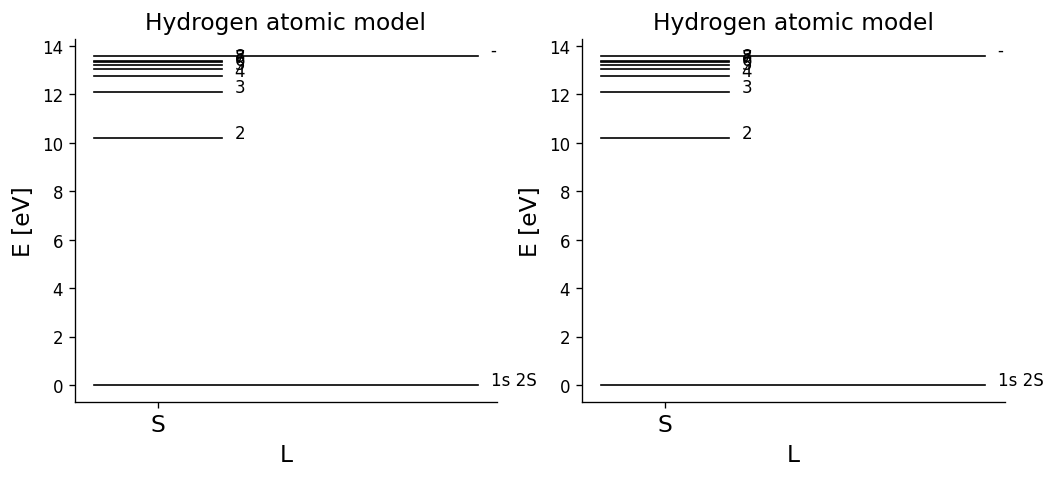

In [19]:
fig, axs = plt.subplots( 1,2, figsize=(10,4), dpi=120 )
gro.make_fig( _fig=fig, _f=50, _removeSpline=('top', 'right') )
gro.make_fig( _axe=axs[0], _f=50 )

#gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)
gro.show_fig()